In [ ]:
import cv2
import re
import pytesseract
from pytesseract import Output

In [2]:
!pip install pytesseract

  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


In [2]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

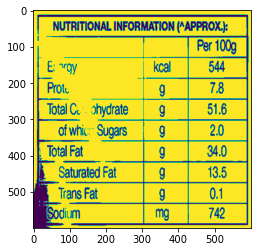

In [10]:
image = cv2.imread('13_1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh_img = thresh.copy()
thresh_img = cv2.resize(thresh_img, (600, 600))

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(thresh_img)

In [11]:
custom_config = r'--oem 3 --psm 6'
# now feeding image to tesseract
details = pytesseract.image_to_data(thresh, output_type=Output.DICT, config=custom_config, lang='eng')
print(details.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [12]:
def boundingBox(details,thresh):
    total_boxes = len(details['text'])
    for sequence_number in range(total_boxes):
        if int(details['conf'][sequence_number]) > 30:
            (x, y, w, h) = (details['left'][sequence_number], details['top'][sequence_number], details['width'][sequence_number],
                details['height'][sequence_number])
            thresh = cv2.rectangle(thresh, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return details,thresh

{'level': [1, 2, 3, 4, 5, 5, 5, 4, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10], 'word_num': [0, 0, 0, 0, 1, 2, 3, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,

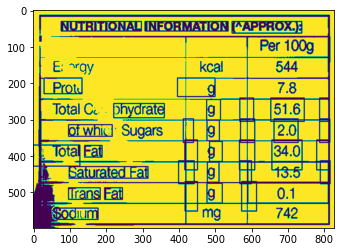

In [14]:
x,y = boundingBox(details,thresh)
print(x)
imshow(y)

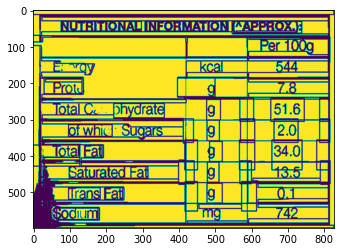

In [15]:
def removeHorizontal(thresh):
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, (0, 0, 0), 2)
    return thresh

x = removeHorizontal(thresh)
imshow(x)

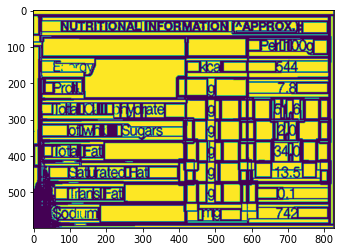

In [16]:
def removeVertical(thresh):
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, (0, 0, 0), 3)
    return thresh

x = removeVertical(thresh)
imshow(x)


In [17]:
# Dilate to connect text and remove dots
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
dilate = cv2.dilate(thresh, kernel, iterations=2)
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 500:
        cv2.drawContours(dilate, [c], -1, (0, 0, 0), -1)

# Bitwise-and to reconstruct image
result = cv2.bitwise_and(image, image, mask=dilate)
result[dilate == 0] = (255, 255, 255)
# imshow(dilate)

# OCR
d = pytesseract.image_to_string(x, lang='eng')
print(d)

 

| {__ NUTRITIONAL INFORMATION APPROX

, Q

| Era Cia 544
EP ——
oaomorydeta | Kl Tl RY TL
_biwameugas—t] idl ff} isl
| SUC: (= AT a [
rade 1 el ist iy
ns 2 |

| Sn

   
      
   
         
     
   

 

  

 

 

 

 

 

 

 

 

 

 



In [ ]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter

im = Image.open('13_1.png') # the second one 
im = im.filter(ImageFilter.MedianFilter())
enhancer = ImageEnhance.Contrast(im)
im = enhancer.enhance(2)
im = im.convert('1')
im.save('temp2.jpg')
text = pytesseract.image_to_string(Image.open('13_1.jpg'))
print(text)

In [ ]:
try:
    cal = re.findall(r"Calories [\w]+", d)
    print(cal[0])
except IndexError:
    print("No information about Calories")
try:
    tof = re.findall(r"Total Fat [\w]+", d)
    print(tof[0])
except IndexError:
    print("No information about Total Fat")
try:
    sf = re.findall(r"Saturated Fat [\w]+", d)
    print(sf[0])
except IndexError:
    print("No information about Saturated Fat")
try:
    tf = re.findall(r"Trans Fat [\w]+", d)
    print(tf[0])
except IndexError:
    print("No information about Trans Fat")
try:
    pf = re.findall(r"Polyunsaturated Fat [\w]+", d)
    print(pf[0])
except IndexError:
    print("No information about Polyunsaturated Fat")
try:
    mf = re.findall(r"Monounsaturated Fat [\w]+", d)
    print(mf[0])
except IndexError:
    print("No information about Monounsaturated Fat")
try:
    ch = re.findall(r"Cholesterol [\w]+", d)
    print(ch[0])
except IndexError:
    print("No information about Cholesterol")
try:
    s = re.findall(r"Sodium [\w]+", d)
    print(s[0])
except IndexError:
    print("No information about Sodium")
try:
    toc = re.findall(r"Total Carbohydrate [\w]+", d)
    print(toc[0])
except IndexError:
    print("No information about Total Carbohydrate")
try:
    fi = re.findall(r"Fiber [\w]+", d)
    print(fi[0])
except IndexError:
    print("No information about Fiber")
try:
    su = re.findall(r"Sugars [\w]+", d)
    print(su[0])
except IndexError:
    print("No information about Sugars")
try:
    p = re.findall(r"Protein [\w]+", d)
    print(p[0])
except IndexError:
    print("No information about Protein")

result = cv2.resize(result, (600, 600))
thresh = cv2.resize(thresh, (600, 600))
cv2.imshow('Bounding Box on Text Area', thresh)
cv2.waitKey(0)
# Maintain output window until user presses a key
cv2.imshow('Result', result)
cv2.waitKey()

No information about Calories
No information about Total Fat
No information about Saturated Fat
No information about Trans Fat
No information about Polyunsaturated Fat
No information about Monounsaturated Fat
No information about Cholesterol
No information about Sodium
No information about Total Carbohydrate
No information about Fiber
No information about Sugars
No information about Protein


In [35]:
import os

import skimage 
from skimage import img_as_float, io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import binary_dilation, binary_erosion, disk, square
from skimage.draw import line
from skimage.transform import hough_line, hough_line_peaks

import numpy as np
import pandas as pd

import scipy 
from scipy import ndimage

import pytesseract
from pytesseract import pytesseract
pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

(257, 196, 3)
Max image value : 255


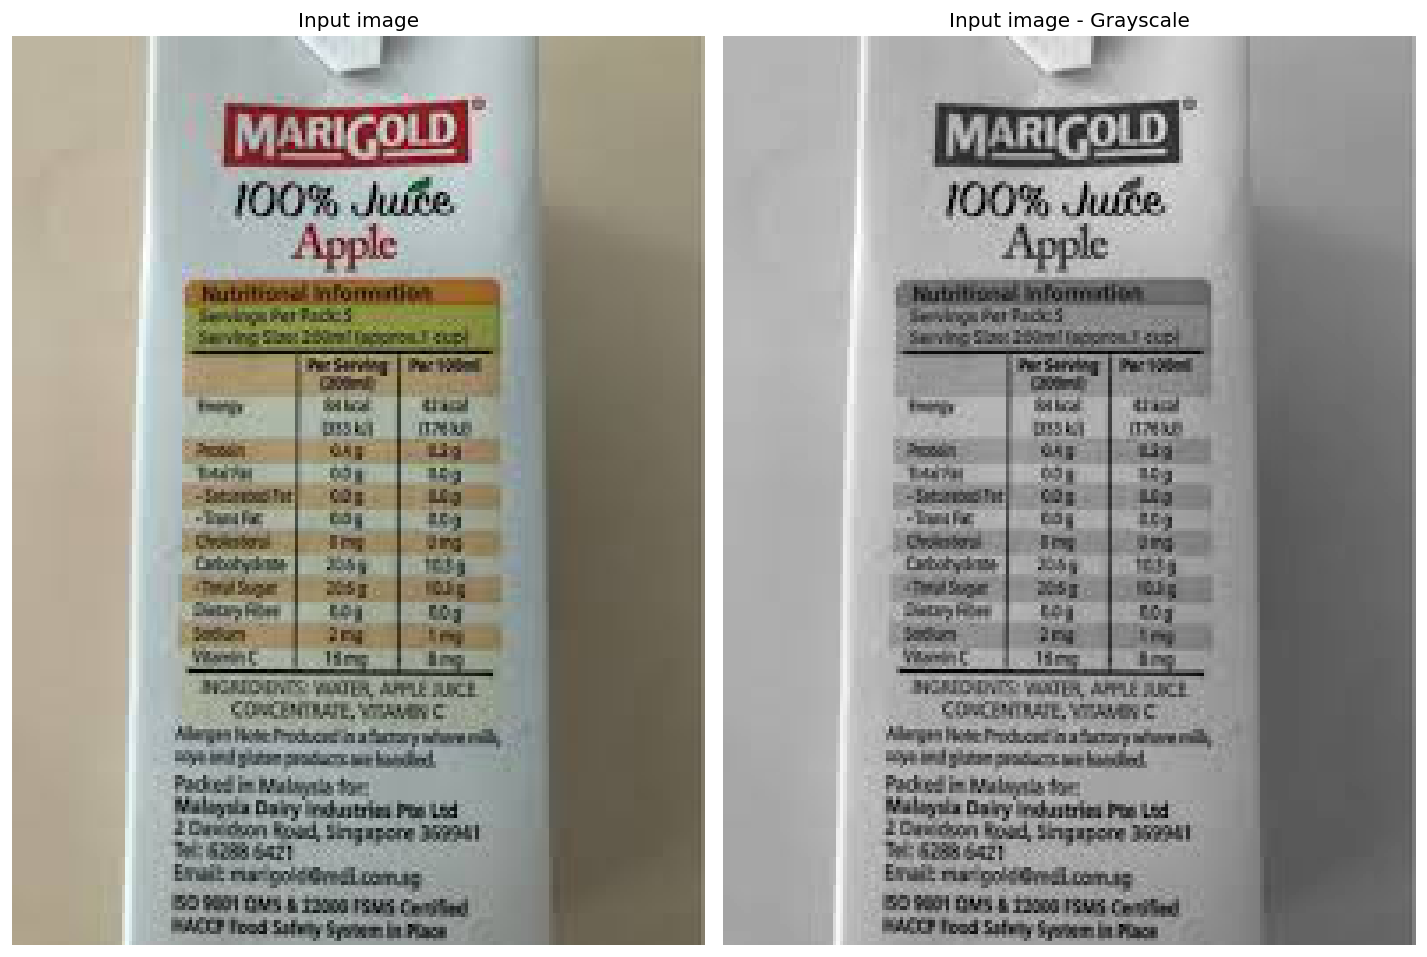

In [75]:
img = io.imread('images.jfif')

import matplotlib.pyplot as plt
print(img.shape)
# print('Image dimensions : (%d, %d, %d)' %(M,N,D) )
print('Max image value : ' + str(img.flatten().max()))

img = img/255.0

img_gray = rgb2gray(img)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 12), dpi = 120)

ax[0].imshow(img, cmap='jet',  vmin = 0, vmax = 1);
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(img_gray, cmap='gray', vmin = 0, vmax = 1);
ax[1].set_title('Input image - Grayscale')
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

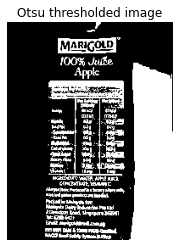

In [76]:
t_otsu = threshold_otsu(img_gray)
img_otsu = img_gray < t_otsu

#figure(figsize = (12, 12), dpi = 120);
imshow(img_otsu, cmap='gray',  vmin = 0, vmax = 1);
plt.title('Otsu thresholded image')
plt.axis('off')
plt.show();

In [77]:
kernel_len = 150 # should be some value (number of pixels) that aproximates number of pixels for the smallest segment of lines in image 
print('Kernel size : ' + str(kernel_len))

kernel_for_horiz = 1/kernel_len * np.ones((1, kernel_len))
kernel_for_vert = 1/kernel_len * np.ones((kernel_len, 1))

img_horizontals = ndimage.correlate(img_otsu, kernel_for_horiz)
img_horizontals = binary_dilation(img_horizontals, disk(radius=5))
horizontal_lines = binary_erosion(img_horizontals, disk(radius = 3))

img_verticals = ndimage.correlate(img_otsu, kernel_for_vert)
img_verticals = binary_dilation(img_verticals, disk(radius=5))
vertical_lines = binary_erosion(img_verticals, disk(radius = 3))

table_lines = horizontal_lines + vertical_lines
data = img_otsu*(~(table_lines))

Kernel size : 150


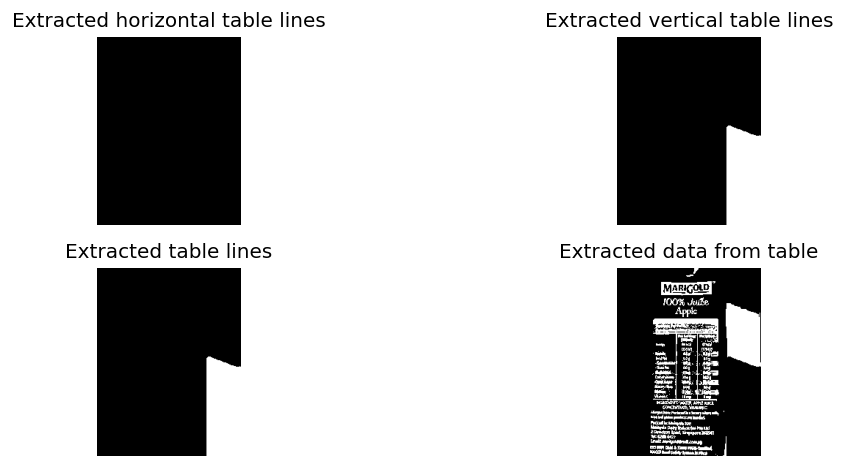

In [78]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 4), dpi = 120)
ax = axes.ravel()

ax[0].imshow(horizontal_lines, cmap='gray',  vmin = 0, vmax = 1);
ax[0].set_title('Extracted horizontal table lines')
ax[0].set_axis_off()

ax[1].imshow(vertical_lines, cmap='gray', vmin = 0, vmax = 1);
ax[1].set_title('Extracted vertical table lines')
ax[1].set_axis_off()

ax[2].imshow(table_lines, cmap='gray', vmin = 0, vmax = 1);
ax[2].set_title('Extracted table lines')
ax[2].set_axis_off()

ax[3].imshow(data, cmap='gray', vmin = 0, vmax = 1);
ax[3].set_title('Extracted data from table')
ax[3].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
hspace, angles, distances = hough_line(horizontal_lines)
_, angles_hor, dists_hor = hough_line_peaks(hspace, angles, distances)

num_horizontals = len(angles_hor)
print('Number of extracted horizontal lines: %d \n' %(num_horizontals))
#(175, 1427, 4)
M = 435
N = 1427
img_hor = np.zeros((M, N))

for i in range(len(angles_hor)):
    theta = angles_hor[i]
    rho = dists_hor[i]
    
    img_one_hor_line_extracted = np.zeros((M,N))

    a = np.cos(theta)
    b = np.sin(theta)

    x0 = a*rho
    y0 = b*rho

    x1 = int(x0 + 3000*(-b))
    y1 = int(y0 + 3000*(a))
    x2 = int(x0 - 3000*(-b))
    y2 = int(y0 - 3000*(a))

    rr, cc = line(y1, x1, y2, x2)

    img_one_hor_line_extracted[rr, cc] = 1
    img_one_hor_line_extracted = binary_dilation(img_one_hor_line_extracted, disk(radius=5))
    img_hor += img_one_hor_line_extracted

figure(figsize = (12, 12), dpi = 120);
imshow(img_hor, cmap='gray',  vmin = 0, vmax = 1)
plt.title('Improved extraction of horizontal table lines using Hough transformation')
plt.axis('off')
plt.show()

In [81]:
hspace, angles, distances = hough_line(horizontal_lines)
_,angles_hor, dists_hor = hough_line_peaks(hspace, angles, distances)

num_horizontals = len(angles_hor)
print('Number of extracted horizontal lines: %d \n' %(num_horizontals))

img_hor = np.zeros((M, N))

for i in range(len(angles_hor)):
    theta = angles_hor[i]
    rho = dists_hor[i]
    
    img_one_hor_line_extracted = np.zeros((M,N))

#     a = np.cos(theta)
#     b = np.sin(theta)

#     x0 = a*rho
#     y0 = b*rho

#     x1 = int(x0 + 3000*(-b))
#     y1 = int(y0 + 3000*(a))
#     x2 = int(x0 - 3000*(-b))
#     y2 = int(y0 - 3000*(a))

#     rr, cc = line(y1, x1, y2, x2)

#     img_one_hor_line_extracted[rr, cc] = 1
#     img_one_hor_line_extracted = binary_dilation(img_one_hor_line_extracted, disk(radius=5))
#     img_hor += img_one_hor_line_extracted

# figure(figsize = (12, 12), dpi = 120);
# imshow(img_hor, cmap='gray',  vmin = 0, vmax = 1)
# plt.title('Improved extraction of horizontal table lines using Hough transformation')
# plt.axis('off')
# plt.show()


Number of extracted horizontal lines: 0 



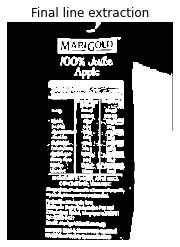

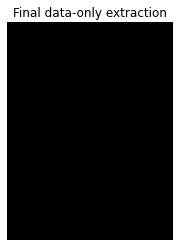

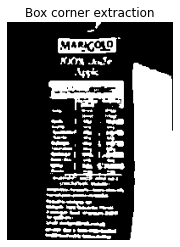

In [83]:
final_extracted_lines = (2+3)*img_otsu
final_extracted_corners = (2*3)*img_otsu

kernel_len = 3
kernel = (1/(kernel_len**2))*np.ones((kernel_len, kernel_len))

final_extracted_corners = skimage.filters.median(final_extracted_corners, kernel)
final_extracted_corners[final_extracted_corners>0] = 1

final_data = img_otsu*(1-final_extracted_lines)

# figure(figsize = (12, 12), dpi = 120);
imshow(final_extracted_lines, cmap='gray',  vmin = 0, vmax = 1)
plt.title('Final line extraction')
plt.axis('off')
plt.show()

# figure(figsize = (12, 12), dpi = 120);
imshow(final_data, cmap='gray',  vmin = 0, vmax = 1)
plt.title('Final data-only extraction')
plt.axis('off')
plt.show()

# figure(figsize = (12, 12), dpi = 120);
imshow(final_extracted_corners, cmap='gray',  vmin = 0, vmax = 1)
plt.title('Box corner extraction')
plt.axis('off')
plt.show()

In [89]:
num_horizontals = 7
num_verticals = 5
def find_box_corners(img, gap_radius=30):

    white_pixels = np.argwhere(img)

    corners = []
    stored_x = []
    stored_y = []

    for pix in white_pixels:
        x = pix[0]
        y = pix[1]

        if not stored_x and not stored_y:
            stored_x.append(x)
            stored_y.append(y)
            corners.append([x, y])

        else:

            cnt = 0
            for el_x, el_y in zip(stored_x, stored_y):
                if abs(x-el_x)>gap_radius or abs(y-el_y)>gap_radius:
                    cnt += 1

            if cnt == len(stored_x):
                stored_x.append(x)
                stored_y.append(y)
                corners.append([x, y])

    return np.array(corners).reshape((len(corners), 2))
  
box_corners = find_box_corners(final_extracted_corners)
num_box_corners = box_corners.shape[0]

print('Number of detected horizontal lines: ' + str(num_horizontals))
print('Number of detected vertical lines: ' + str(num_verticals))
print('Expected number of box corners to be detected: ' + str(num_verticals*num_horizontals))
print('Number of detected box corners: ' + str(num_box_corners))

if num_verticals*num_horizontals == num_box_corners:
    print('Expected number of fields/boxes: ' + str((num_verticals-1)*(num_horizontals-1)))
    print('Expected number of table rows: ' + str(num_horizontals-1))
    print('Expected number of table colums: ' + str(num_verticals-1))

    num_boxes = num_box_corners
    num_table_rows = num_horizontals-1
    num_table_cols = num_horizontals-1
else:
    print('Number of detected box corners missmatch expected number of box corners to be detected!')

Number of detected horizontal lines: 7
Number of detected vertical lines: 5
Expected number of box corners to be detected: 35
Number of detected box corners: 35
Expected number of fields/boxes: 24
Expected number of table rows: 6
Expected number of table colums: 4


In [3]:
def sort_corners(box_corners, num_table_rows, num_table_cols, gap_radius=50):
  
    left_corners = list(np.squeeze(box_corners[np.argwhere(box_corners[:,1]<100)]))

    box_corners_list = []

    for corner in box_corners:
        x = corner[0]
        y = corner[1]
        box_corners_list.append([x, y])

    sorted_corners = []

    for row in range(num_table_rows+1):

        row_corners = []
        corner = list(left_corners[row])
        row_corners.append(corner)

        box_corners_list.remove(corner)
        box_corners = np.array(box_corners_list)

        for col in range(num_table_cols):
            corners_on_right = np.squeeze(box_corners[np.argwhere(abs(box_corners[:,0]-corner[0])<gap_radius)])
            if col < num_table_cols-1:
                corners_on_right = np.squeeze(corners_on_right[np.argwhere(abs(corners_on_right[:,1]-corner[1])>gap_radius)])
                corner_on_right = np.squeeze(corners_on_right[np.argmin(corners_on_right[:,1])])
            else:
                corner_on_right = np.squeeze(corners_on_right)

            corner = list(corner_on_right)

#             box_corners_list.remove(corner)
            box_corners = np.array(box_corners_list)

            row_corners.append(corner)

        sorted_corners.append(row_corners)

    return sorted_corners

def get_boxes(img, sorted_corners, num_table_rows, num_table_cols):

    fig, axes = plt.subplots(nrows=num_table_rows, ncols=num_table_cols, figsize=(20,8), dpi=120)
    ax = axes.ravel()

    fields_dict = {}

    for row in range(num_table_rows):
        for col in range(num_table_cols):
            x0, y0 = sorted_corners[row][col]
            x1, y1 = sorted_corners[row][col+1]
            x2, y2 = sorted_corners[row+1][col]
            x3, y3 = sorted_corners[row+1][col+1]

            field = img[min(x0, x1):max(x2, x3), min(y0, y2):max(y1, y3)]
            field_name = 'row_' + str(row) + '_col_' + str(col) 

            io.imsave('extracted_fields/' + img_name + '/' + field_name + '.jpg', uint8(255*(1-field)))

            ax[row*num_table_cols+col].imshow(field, cmap='gray', vmin=0, vmax=1)
            ax[row*num_table_cols+col].set_title('Field: ' + field_name)
            ax[row*num_table_cols+col].set_axis_off()

sorted_corners = sort_corners(box_corners, num_table_rows, num_table_cols)
get_boxes(final_data, sorted_corners, num_table_rows, num_table_cols)

print(nt)
print(amt)
print(pcnt)

['Calories', 'Total Fat', 'Saturated Fat', 'Trans Fat', 'Cholestrol', 'Sodium', 'Total Carbohydrate', 'Dietary Fiber', 'Sugars', 'Protein']
['0g', '0g', '0g', '0mg', '25.52mg', '8.48g', '0g', '0g', '0.80g']
['0%', '0%', 'Nan', 'Nan', '0%', '3%', '8%', '0%', 'Nan', '0%']
